In [ ]:
#danaderp May6'19
#Prediction For Main Issues Data Set

In [ ]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

/scratch/danaderp/.conda/envs/drmccr_conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# visualize model structure
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

In [ ]:
from datasets.read_data import Dynamic_Dataset,Processing_Dataset
from vectorize_sentence import Embeddings

In [ ]:
path = "datasets/augmented_dataset/"
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [ ]:
dataset = Dynamic_Dataset(ground_truth, path)

In [ ]:
test, train = process_unit.get_test_and_training(ground_truth)

In [ ]:
print(len(test))
print(len(train))
print(test[0])
print(train[0])

11612
104510
('(1,0)', 'OSRAM SYLVANIA Osram Lightify Home before 2016-07-26 allows remote attackers to execute arbitrary commands via TCP port 4000.')
('(1,0)', 'The currently used Rails version, in the stable branch, is insecure\n\nYou should update the Gemfile.lock to hotfix this.\n\nhttp://weblog.rubyonrails.org/2014/2/18/Rails_3_2_17_4_0_3_and_4_1_0_beta2_have_been_released/')


In [ ]:
#Train/Test split verification
#for elem in test:
#    print(elem[0])

In [ ]:
#Preprocesing Corpora
embeddings = Embeddings()
max_words = 5000 #<------- [Parameter]
pre_corpora_train = [doc for doc in train if len(doc[1])< max_words]
pre_corpora_test = [doc for doc in test if len(doc[1])< max_words]

In [ ]:
print(len(pre_corpora_train))
print(len(pre_corpora_test))

103862
11553


In [ ]:
embed_path = 'datasets/word_embeddings-embed_size_100-epochs_100.csv'
embeddings_dict = embeddings.get_embeddings_dict(embed_path)

In [ ]:
corpora_train = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_train]#vectorization Inputs
corpora_test = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_test]#vectorization

In [ ]:
target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in pre_corpora_train]#vectorization Output
target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in pre_corpora_test]#vectorization Output
#target_train

In [ ]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [ ]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 618


In [ ]:
embed_size = np.size(corpora_train[0][0])

In [ ]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 512 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [ ]:
input_sh

(618, 100, 1)

In [ ]:
#baseline_model = Sequential()
gram_input = Input(shape = input_sh)

In [ ]:
# 1st Convolutional Layer (1-gram)
conv_filter_1_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(1,embeddigs_cols), padding='valid',data_format="channels_last")(gram_input)

In [ ]:
# 2sd Convolutional Layer (3-gram)
conv_filter_3_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(3,embeddigs_cols), padding='valid')(gram_input)

In [ ]:
# 3rd Convolutional Layer (5-gram)
conv_filter_5_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(5,embeddigs_cols), padding='valid')(gram_input)

In [ ]:
print(conv_filter_1_gram.shape)
print(conv_filter_3_gram.shape)
print(conv_filter_5_gram.shape)

(None, 618, 1, 512)
(None, 616, 1, 512)
(None, 614, 1, 512)


In [ ]:
# Max Pooling Layer
max_pool_1_gram = MaxPooling2D(pool_size=((max_len_sentences-1+1), 1), strides=None, padding='valid')(conv_filter_1_gram)
max_pool_3_gram = MaxPooling2D(pool_size=((max_len_sentences-3+1), 1), strides=None, padding='valid')(conv_filter_3_gram)
max_pool_5_gram = MaxPooling2D(pool_size=((max_len_sentences-5+1), 1), strides=None, padding='valid')(conv_filter_5_gram)

In [ ]:
print(max_pool_1_gram.shape)
print(max_pool_3_gram.shape)
print(max_pool_5_gram.shape)

(None, 1, 1, 512)
(None, 1, 1, 512)
(None, 1, 1, 512)


In [ ]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_pool_1_gram)
fully_connected_3_gram = Flatten()(max_pool_3_gram)
fully_connected_5_gram = Flatten()(max_pool_5_gram)

In [ ]:
print(fully_connected_1_gram.shape)
print(fully_connected_3_gram.shape)
print(fully_connected_5_gram.shape)

(None, 512)
(None, 512)
(None, 512)


In [ ]:
fully_connected_1_gram = Reshape((N_filters, 1, 1))(fully_connected_1_gram)
fully_connected_3_gram = Reshape((N_filters, 1, 1))(fully_connected_3_gram)
fully_connected_5_gram = Reshape((N_filters, 1, 1))(fully_connected_5_gram)

In [ ]:
print(fully_connected_1_gram.shape)
print(fully_connected_3_gram.shape)
print(fully_connected_5_gram.shape)

(None, 512, 1, 1)
(None, 512, 1, 1)
(None, 512, 1, 1)


In [ ]:
#Second Phase of the Convolution
# 1st Convolutional Layer (1-gram)
conv_filter_1_gram = Conv2D(filters= 128, activation='relu', 
                       kernel_size=(1,1), padding='valid')(fully_connected_1_gram)

In [ ]:
conv_filter_1_gram.shape

TensorShape([None, 512, 1, 128])

In [ ]:
# 2sd Convolutional Layer (3-gram)
conv_filter_3_gram = Conv2D(filters= 128, activation='relu', 
                       kernel_size=(3,1), padding='valid')(fully_connected_3_gram)

In [ ]:
conv_filter_3_gram.shape

TensorShape([None, 510, 1, 128])

In [ ]:
# 3rd Convolutional Layer (5-gram)
conv_filter_5_gram = Conv2D(filters= 128, activation='relu', 
                       kernel_size=(5,1), padding='valid')(fully_connected_5_gram)

In [ ]:
conv_filter_5_gram.shape

TensorShape([None, 508, 1, 128])

In [ ]:
# Max Pooling Layer
max_pool_1_gram = MaxPooling2D(pool_size=((N_filters-1+1), 1), strides=None, padding='valid')(conv_filter_1_gram)
max_pool_3_gram = MaxPooling2D(pool_size=((N_filters-3+1), 1), strides=None, padding='valid')(conv_filter_3_gram)
max_pool_5_gram = MaxPooling2D(pool_size=((N_filters-5+1), 1), strides=None, padding='valid')(conv_filter_5_gram)

In [ ]:
print(max_pool_1_gram.shape)
print(max_pool_3_gram.shape)
print(max_pool_5_gram.shape)

(None, 1, 1, 128)
(None, 1, 1, 128)
(None, 1, 1, 128)


In [ ]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_pool_1_gram)
fully_connected_3_gram = Flatten()(max_pool_3_gram)
fully_connected_5_gram = Flatten()(max_pool_5_gram)

In [ ]:
print(fully_connected_1_gram.shape)
print(fully_connected_3_gram.shape)
print(fully_connected_5_gram.shape)

(None, 128)
(None, 128)
(None, 128)


In [ ]:
merged_vector = layers.concatenate([fully_connected_1_gram, fully_connected_3_gram, 
                                    fully_connected_5_gram], axis=-1)

integration_layer = Dropout(0.2)(merged_vector) # <-------- [HyperParameter]

In [ ]:
#Extra Hidden Layer
deep_dense_layer = Dense(N_filters, activation='relu')(integration_layer)
deep_dense_layer = Dropout(0.2)(deep_dense_layer) # <-------- [HyperParameter]

In [ ]:
predictions = Dense(K, activation='softmax')(deep_dense_layer)

In [ ]:
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [ ]:
print(criticality_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 618, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 618, 1, 512)  51712       input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 1, 1, 512)    0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 616, 1, 512)  154112      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

In [ ]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [ ]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'f-res_temp_corpora_train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'f-res_temp_corpora_test_x.dat')

In [ ]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [ ]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [ ]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [ ]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [ ]:
corpora_train_x.shape

(103862, 618, 100, 1)

In [ ]:
target_train_y.shape

(103862, 2)

In [ ]:
corpora_test_x.shape

(11553, 618, 100, 1)

In [ ]:
target_test_y.shape

(11553, 2)

In [ ]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [ ]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [ ]:
#CheckPoints
#csv_logger = CSVLogger(system+'_training.log')
filepath = "f-res/best_model.hdf5"

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [es,mc]

In [ ]:
#Model Fitting
history = criticality_network.fit(
            x = corpora_train_x, 
            y = target_train_y,
            #batch_size=64,
            epochs=2000, #5 <------ Hyperparameter
            validation_split = 0.2,
            callbacks=callbacks_list
)

Train on 83089 samples, validate on 20773 samples
Epoch 1/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.1510 - accuracy: 0.9472
Epoch 00001: val_accuracy improved from -inf to 0.99649, saving model to f-res/best_model.hdf5
83089/83089 [==============================] - 330s 4ms/sample - loss: 0.1510 - accuracy: 0.9472 - val_loss: 0.0075 - val_accuracy: 0.9965
Epoch 2/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9617
Epoch 00002: val_accuracy did not improve from 0.99649
83089/83089 [==============================] - 338s 4ms/sample - loss: 0.1126 - accuracy: 0.9617 - val_loss: 0.0109 - val_accuracy: 0.9955
Epoch 3/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.1007 - accuracy: 0.9652
Epoch 00003: val_accuracy improved from 0.99649 to 0.99653, saving model to f-res/best_model.hdf5
83089/83089 [==============================] - 346s 4ms/sample - loss: 0.1008 - accuracy: 0.9652 - val_loss: 0.0075 - 

83072/83089 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.9949
Epoch 00028: val_accuracy did not improve from 0.99832
83089/83089 [==============================] - 377s 5ms/sample - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0086 - val_accuracy: 0.9976
Epoch 29/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9944
Epoch 00029: val_accuracy did not improve from 0.99832
83089/83089 [==============================] - 374s 5ms/sample - loss: 0.0179 - accuracy: 0.9944 - val_loss: 0.0226 - val_accuracy: 0.9947
Epoch 30/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9942
Epoch 00030: val_accuracy did not improve from 0.99832
83089/83089 [==============================] - 376s 5ms/sample - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.0185 - val_accuracy: 0.9963
Epoch 31/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9948
Epoch 00031: val_acc

Epoch 56/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9967
Epoch 00056: val_accuracy did not improve from 0.99832
83089/83089 [==============================] - 382s 5ms/sample - loss: 0.0120 - accuracy: 0.9967 - val_loss: 0.0238 - val_accuracy: 0.9969
Epoch 57/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9967
Epoch 00057: val_accuracy did not improve from 0.99832
83089/83089 [==============================] - 384s 5ms/sample - loss: 0.0126 - accuracy: 0.9967 - val_loss: 0.0182 - val_accuracy: 0.9967
Epoch 58/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.9968
Epoch 00058: val_accuracy did not improve from 0.99832
83089/83089 [==============================] - 382s 5ms/sample - loss: 0.0122 - accuracy: 0.9968 - val_loss: 0.0152 - val_accuracy: 0.9965
Epoch 59/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9970
Epoch 

Epoch 84/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9975
Epoch 00084: val_accuracy did not improve from 0.99832
83089/83089 [==============================] - 307s 4ms/sample - loss: 0.0106 - accuracy: 0.9975 - val_loss: 0.0227 - val_accuracy: 0.9960
Epoch 85/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9978
Epoch 00085: val_accuracy did not improve from 0.99832
83089/83089 [==============================] - 313s 4ms/sample - loss: 0.0108 - accuracy: 0.9978 - val_loss: 0.0395 - val_accuracy: 0.9939
Epoch 86/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9975
Epoch 00086: val_accuracy did not improve from 0.99832
83089/83089 [==============================] - 306s 4ms/sample - loss: 0.0108 - accuracy: 0.9975 - val_loss: 0.0206 - val_accuracy: 0.9966
Epoch 87/2000
83072/83089 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9974
Epoch 

In [ ]:
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv('f-res/history_training.csv', encoding='utf-8',index=False)

In [ ]:
df_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.947249,0.150975,0.996486,0.007508
1,0.961680,0.112626,0.995475,0.010928
2,0.965158,0.100765,0.996534,0.007520
3,0.968841,0.090637,0.998315,0.004767
4,0.971741,0.081611,0.995667,0.010286


In [ ]:
#Saving Test Data
np.save('f-res/corpora_test_x.npy',corpora_test_x)
np.save('f-res/target_test_y.npy',target_test_y)

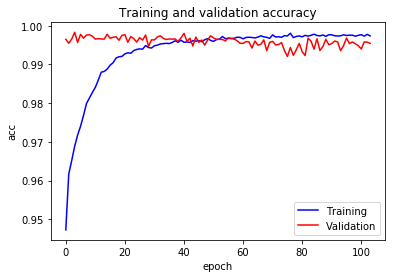

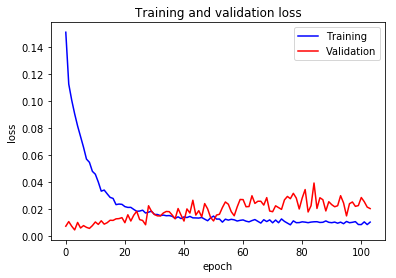

In [ ]:
#Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score,precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
path = 'f-res/best_model.hdf5'
criticality_network_load = load_model(path) #<----- The Model

In [ ]:
score = criticality_network_load.evaluate(corpora_test_x, target_test_y, verbose=1)

11553/11553 [==============================] - 11s 942us/sample - loss: 0.0897 - accuracy: 0.9691


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0896831521055043
Test accuracy: 0.9690989


In [ ]:
history_predict = criticality_network_load.predict(x=corpora_test_x)
history_predict

array([[1.0000000e+00, 7.9988111e-10],
       [7.7354908e-03, 9.9226451e-01],
       [1.0000000e+00, 3.0692110e-10],
       ...,
       [4.3467302e-03, 9.9565327e-01],
       [1.0000000e+00, 1.5595104e-08],
       [9.1771345e-04, 9.9908233e-01]], dtype=float32)

In [ ]:
inferred_data = pd.DataFrame(history_predict,columns=list('AB'))
target_data = pd.DataFrame(target_test_y,columns=list('LN'))
data = target_data.join(inferred_data)

In [ ]:
y_true = list(data['L'])
y_score= list(data['A'])
average_precision = average_precision_score(y_true, y_score)

In [ ]:
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.99


In [ ]:
#ROC Curve (all our samples are balanced)
auc = roc_auc_score(y_true, y_score)
print('AUC: %.3f' % auc)

AUC: 0.993
